# Combining Token Subspaces

> In this notebook, I investigate how to combine token subspace approximations in predictable ways.

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
import gc
from pathlib import Path
from typing import Callable, Dict, List, Optional, Iterable, Sequence, Tuple

In [ ]:
#| hide
from fastcore.test import *
import math
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.svd_helpers import adjust_singular_vector_sign
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
)
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.environments import get_environment
from transformer_experiments.models.transformer import (
    block_size,
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer,
    FilenameForToken,
)
from transformer_experiments.experiments.cosine_sims import (
    filter_on_prefiltered_results,
)


## Preliminaries

In [ ]:
environment = get_environment()
print(f"environment is {environment.name}")

environment is local_mac


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file=environment.code_root / 'nbs/artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename=environment.code_root / 'nbs/artifacts/shakespeare-20231112.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9, device=device)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
learned_embeddings_dir = environment.data_root / 'learned_embeddings'
assert learned_embeddings_dir.exists(), "Learned embeddings directory doesn't exist. Run the code in experiments/learn-embeddings.ipynb to learn embeddings."

In [ ]:
filename_for_token = FilenameForToken(tokenizer)

In [ ]:
# Load embeddings for 'a' and 'b'
embs_a = torch.load(learned_embeddings_dir / 'no_blocks' / f'{filename_for_token("a")}.pt', map_location=device)[:, -1, :]
embs_b = torch.load(learned_embeddings_dir / 'no_blocks' / f'{filename_for_token("b")}.pt', map_location=device)[:, -1, :]

# Perform SVD on both
_, _, Va = torch.linalg.svd(embs_a)
_, _, Vb = torch.linalg.svd(embs_b)

# Grab the first singular vector from each and adjust the sign.
v0a = adjust_singular_vector_sign(Va[0], embs_a)
v0b = adjust_singular_vector_sign(Vb[0], embs_b)


At this point `v0a` and `v0b` serve as approximations for the token spaces for `a` and `b` respectively. 

In [ ]:
# Helper to plot the probability distribution of next tokens from an embedding
def plot_probs(emb: torch.Tensor, title: str=''):
    logits = LogitsWrapper(accessors.logits_from_embedding(unsqueeze_emb(emb)), tokenizer)
    logits.plot_probs(title=title)

Plot them just as a sanity check.

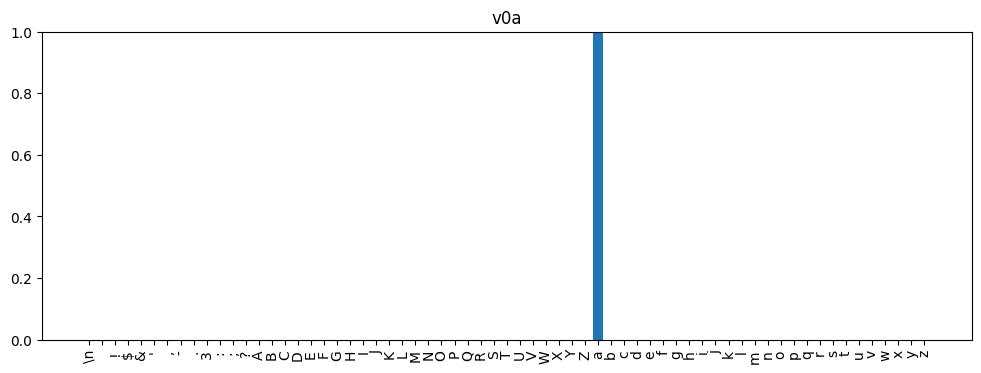

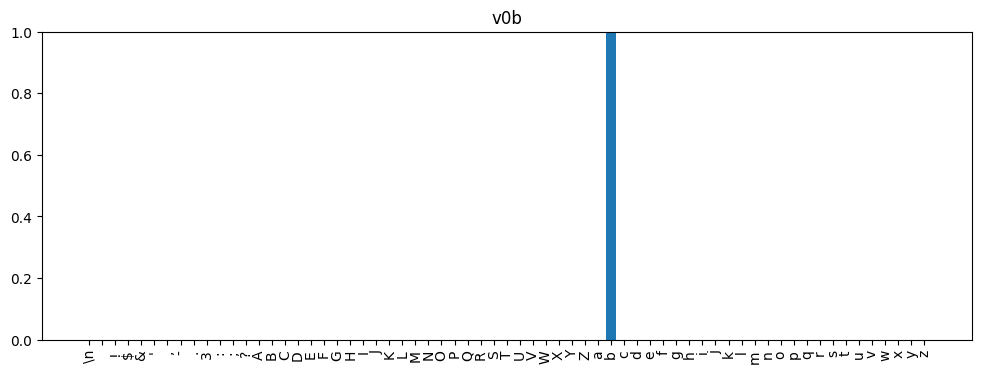

In [ ]:
plot_probs(v0a, title='v0a')
plot_probs(v0b, title='v0b')

We'd expect that if we add `v0a` and `v0b`, we'd get a distribution that predicted 50% for 'a' and 50% for 'b'. But alas:

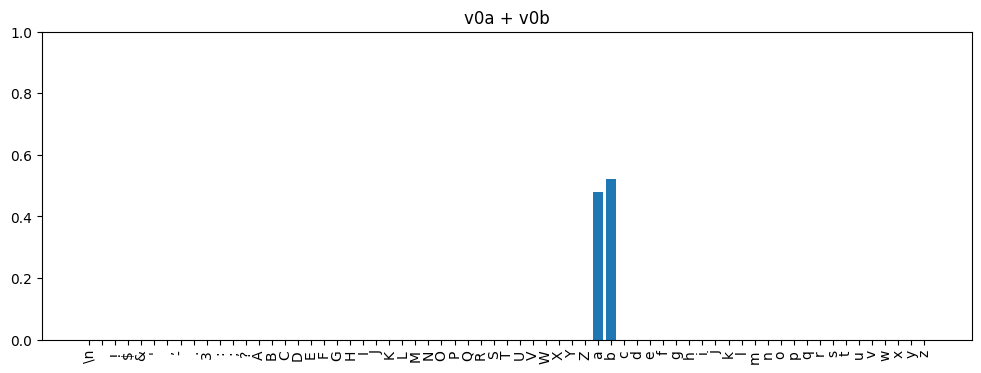

In [ ]:
plot_probs(v0a+v0b, title='v0a + v0b')

They're not quite even. And there are worse examples:

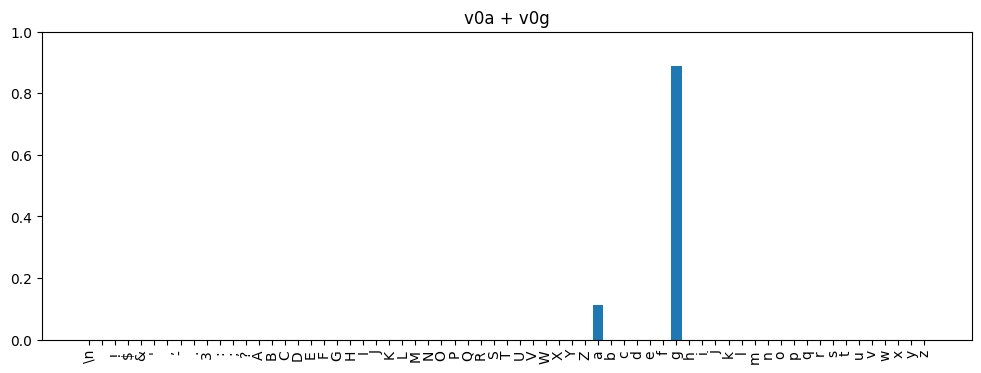

In [ ]:
# Load embeddings for 'g'
embs_g = torch.load(learned_embeddings_dir / 'no_blocks' / f'{filename_for_token("g")}.pt', map_location=device)[:, -1, :]

# Perform SVD
_, _, Vg = torch.linalg.svd(embs_g)

# Grab the first singular vector from each and adjust the sign.
v0g = adjust_singular_vector_sign(Vg[0], embs_g)

plot_probs(v0a + v0g, title='v0a + v0g')


Three factors contribute: 

1. The approximations for the token spaces are not perfect. 
2. The two vectors are not perfectly orthogonal. To the extent that `v0a` has a small component that points in the direction of `v0b`, the sum results in an overweighting of `b`. 
3. The final linear layer of the model produces logits of different magnitudes for different tokens. For example, given `v0a`, the logit for `a` is ~18.2. The logit for `b` from `v0b` is ~19.5.

1 is not something we can much about without expending a lot more resources to find a better approximation. But 2 and 3 we can compensate for. 

## Compensating for Non-Orthogonality

Let's look at the orthogonality of the vectors for `b` and `g` relative to `a`: 

In [ ]:
v0a.dot(v0b), v0a.dot(v0g)

(tensor(0.0054), tensor(-0.0317))

If they were orthogonal, we'd expect the dot products to be zero. They are close to zero, but $v0a \cdot v0b$ is an order of magnitude closer to zero than $v0a \cdot v0g$.

Let's see what happens if we adjust `v0a` to make it orthogonal to `v0b` by removing the component that's in line with `v0b`:

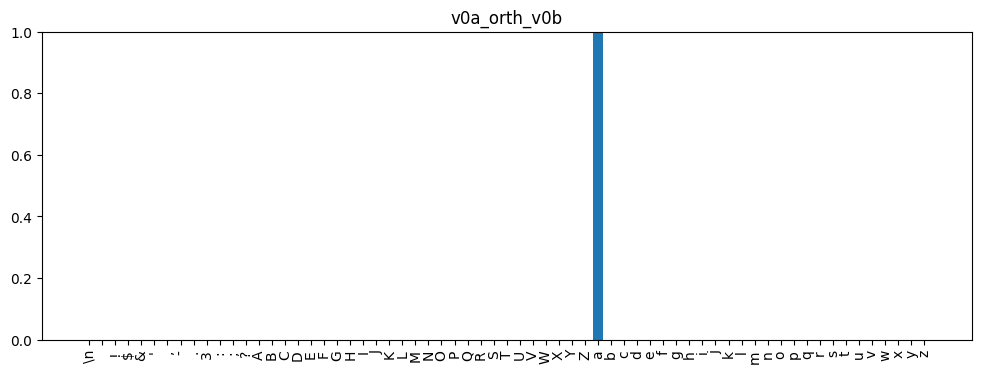

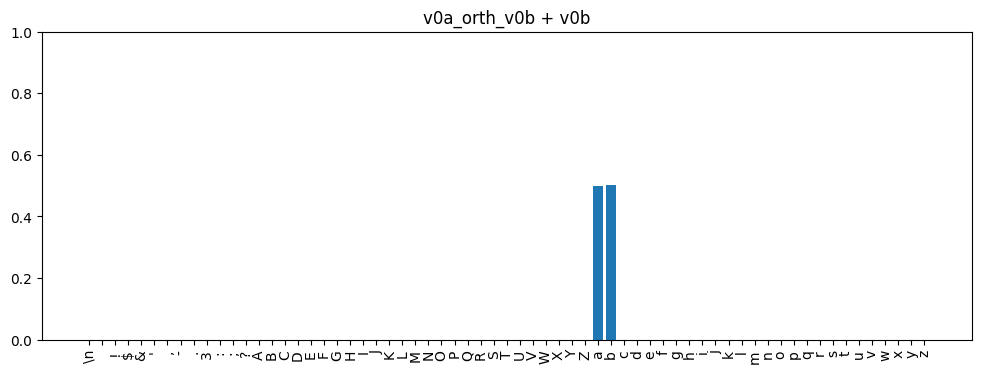

In [ ]:
v0a_orth_v0b = v0a - v0a.dot(v0b) * v0b
plot_probs(v0a_orth_v0b, title='v0a_orth_v0b')
plot_probs(v0a_orth_v0b + v0b, title='v0a_orth_v0b + v0b')

After removing the component in the direction of `v0b`, what's left of `v0a` still results in a distribution that selects `a` with near certainty. And when we add them, we get much closer to a 50/50 split. Let's try the same with `v0g`:

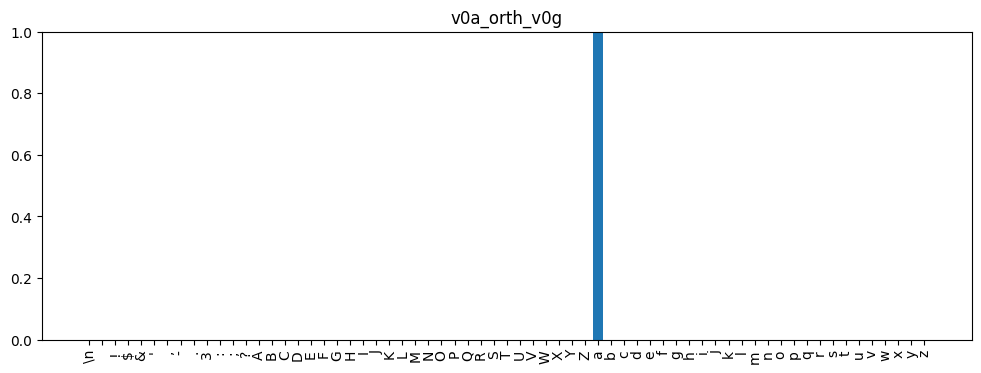

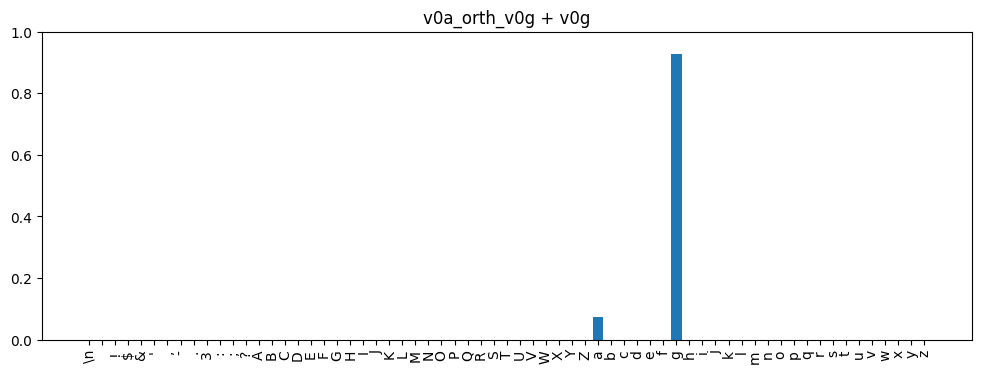

In [ ]:
v0a_orth_v0g = v0a - v0a.dot(v0g) * v0g
plot_probs(v0a_orth_v0g, title='v0a_orth_v0g')
plot_probs(v0a_orth_v0g + v0g, title='v0a_orth_v0g + v0g')

Sadly, this doesn't help, and in fact seems to make things a little worse. We've got to look at the logit magnitude too. 

## Compensating for Logit Magnitude

Let's look at what logit values are produced from each of the vectors:

In [ ]:
logit_for_char = lambda v, char: accessors.logits_from_embedding(unsqueeze_emb(v))[0, 0, tokenizer.stoi[char]]
(
    logit_for_char(v0a, 'a'),
    logit_for_char(v0b, 'b'),
    logit_for_char(v0g, 'g'),
)

(tensor(18.1589), tensor(19.5089), tensor(21.7159))

For `a`, the relevant logit is ~18.2 vs ~19.5 for `b` and ~21.7 for `g`. These may seem like small differences but the softmax function really exaggerates them. We can see this with some sample data where all the elements are -1 except for index 2 which is 18.2 and index 5 which is 19.5:

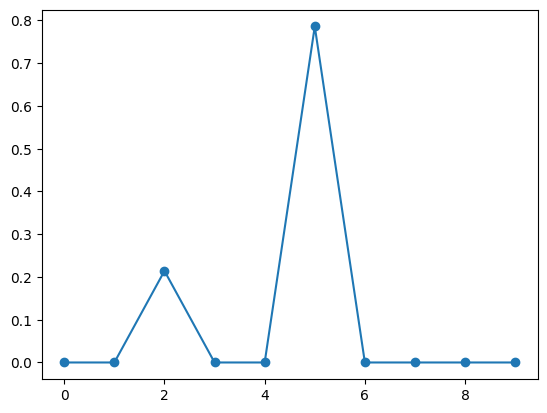

In [ ]:
test_data = torch.zeros(10)
test_data = test_data - 1
test_data[2] = 18.2
test_data[5] = 19.5
_ = plt.plot(F.softmax(test_data, dim=0).numpy(), '-o')

The effect when it's 18.2 vs 21.7 (`g`'s logit value) is even more stark:

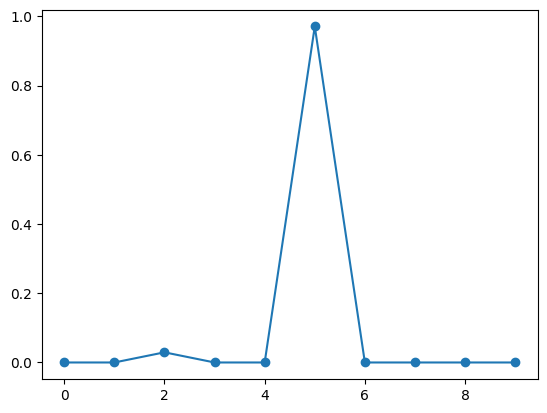

In [ ]:
test_data[5] = 21.7
_ = plt.plot(F.softmax(test_data, dim=0).numpy(), '-o')

So these small difference have a big impact. What happens if we compensate for them?

In a sense, a bigger logit value for one embedding vs another means the model is more "sensitive" to that embedding. In the sum, we'd need more of the embedding the model is less sensitive to to end up with a 50/50 distribution. 

We can try scaling `v0a_orth_v0g` by the ratio of the logit values:

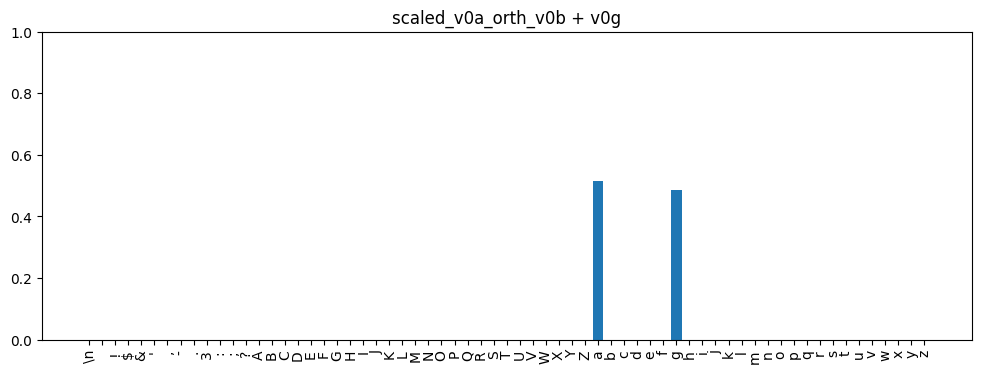

In [ ]:
scaled_v0a_orth_v0b = (logit_for_char(v0g, "g") / logit_for_char(v0a_orth_v0g, "a")) * v0a_orth_v0g
plot_probs(
    scaled_v0a_orth_v0b + v0g,
    title="scaled_v0a_orth_v0b + v0g",
)

This results in a much more even distribution. It's still not quite perfectly 50/50 and I suspect the remaining error is due to the imperfect approximations. 